# Comparison between artifical language and natural language
## A comparison between PCFG generated data and the Penn Tree Bank data

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.patches as mpatches
import os
import string
import scipy.optimize as opt
import matplotlib.colors as mcolors
import random

In [3]:
PTB = []
sentences_results_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/PTB/penn-sentences.txt')
with open(sentences_results_path) as f:
    for i, sentence in enumerate(f.readlines()):
        PTB.append(sentence.split(' '))

In [4]:
AL = []
AL_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/corpora/eval.txt')
with open(AL_path) as f:
    for i, sentence in enumerate(f.readlines()):
        AL.append(sentence.split(' '))

## Length of sentences

In [5]:
def stats_dataset(dataset):
    print(
    f"""The length of the AL corpus is {len(dataset)}.
    The maximum length is {max(dataset)}. 
    The minimum length is {min(dataset)}.""")

In [6]:
lengthsAL = [len(i) for i in AL]
stats_dataset(lengthsAL)

The length of the AL corpus is 10000.
    The maximum length is 19. 
    The minimum length is 7.


In [7]:
# PTB
cutoff_max = 20
cutoff_min = 6
lengthsPTB = [len(i) for i in PTB if len(i) < cutoff_max and len(i) > cutoff_min]
stats_dataset(lengthsPTB)

The length of the AL corpus is 11406.
    The maximum length is 19. 
    The minimum length is 7.


In [8]:
def plot_length_dist(dataset, name):
    # plot smooth distribution of sentence lengths
    density = gaussian_kde(dataset)
    x = np.linspace(min(dataset), max(dataset), len(dataset))

    plt.hist(dataset, bins=10, density=True, alpha=0.7, label='PTB')
    plt.plot(x, density(x), color='#FF7F0E')
    plt.fill_between(x, density(x), alpha=0.5, color='#FF7F0E')
    plt.xlabel('Sentence length')
    plt.title(f'Distribution of sentence lengths of {name}')

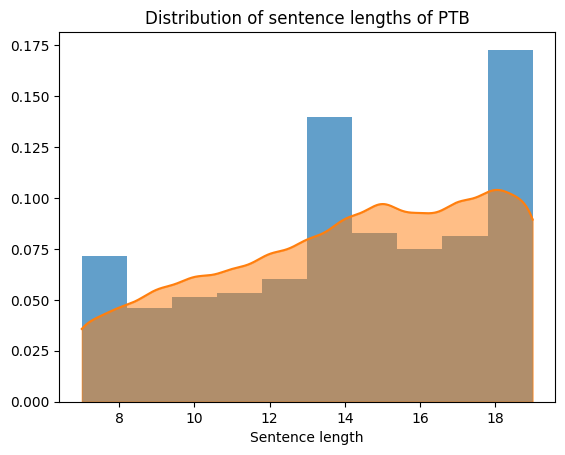

In [9]:
plot_length_dist(lengthsPTB, 'PTB')

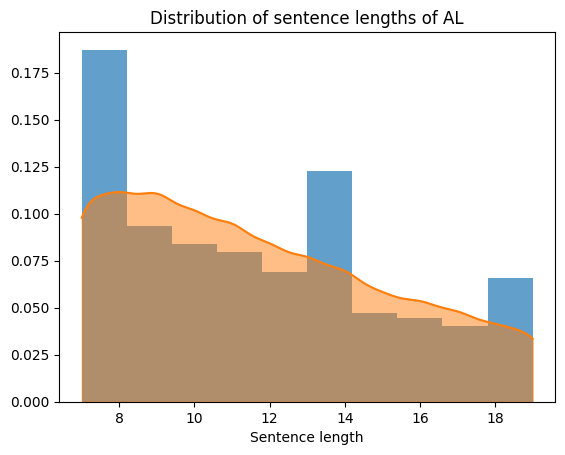

In [10]:
plot_length_dist(lengthsAL, 'AL')

In [11]:
def plot_comparison_dist(dataset1, dataset2, name1, name2):
    # plot smooth distribution of sentence lengths
    density1 = gaussian_kde(dataset1)
    density2 = gaussian_kde(dataset2)
    x1 = np.linspace(min(dataset1), max(dataset1), len(dataset1))
    x2 = np.linspace(min(dataset2), max(dataset2), len(dataset2))

    plt.plot(x1, density1(x1), color='#FF7F0E')
    plt.fill_between(x1, density1(x1), alpha=0.5, color='#FF7F0E')
    o_patch = mpatches.Patch(edgecolor='#FF7F0E', facecolor='#FFBF86', label=f'{name1}')

    plt.plot(x2, density2(x2), color='#1F77B4', label=f'Distr of {name2}')
    plt.fill_between(x2, density2(x2), alpha=0.5, color='#1F77B4')
    b_patch = mpatches.Patch(edgecolor='#1F77B4', facecolor='#8FBBD9', label=f'{name2}')

    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.get_yaxis().set_visible(False)   
    plt.xlabel('Sentence length')
    plt.title(f'Distribution of sentence lengths of {name1} and {name2}')
    plt.legend(handles=[o_patch, b_patch])

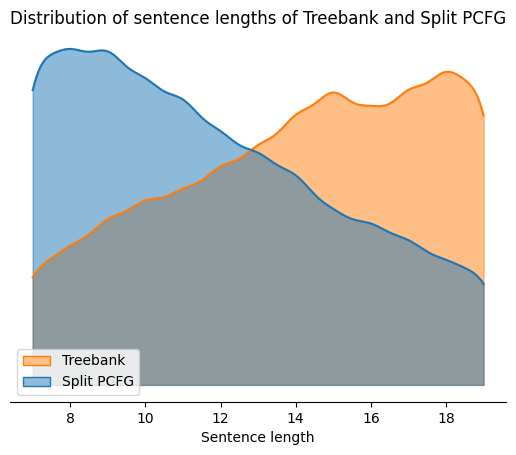

In [12]:
plot_comparison_dist(lengthsPTB, lengthsAL, 'Treebank', 'Split PCFG')

## Zipf curve

In [13]:
def create_vocab(data):
    unwantedCharacters = list(string.punctuation)

    vocab = defaultdict(int)
    # Cleaning and counting the Text
    for text in data:
        for word in text:
            # Remove unwanted characters from the texts
            if word in unwantedCharacters:
                text.remove(word)
                continue

            vocab[word] += 1

    return vocab


def zipf_equation(x, alpha, beta):
    return 1/(x+beta)**alpha


def Zipf_curve(data):
    vocab = create_vocab(data)

    freq = np.zeros(len(vocab.keys()))
    rank = np.zeros(len(vocab.keys()))
    for i, count in enumerate(vocab.values()):
        sample = np.random.binomial(count, 0.5)
        freq[i] = sample
        rank[i] = count - sample
    
    indices = np.argsort(rank)[::-1]
    rank = np.sort(rank[::-1])
    freq = freq[indices]
    freq = freq / np.linalg.norm(freq)
    x_values = np.arange(1, len(vocab.keys())+1)

    # Fit Eq. 2 to the data
    params, _ = opt.curve_fit(zipf_equation, x_values, freq, maxfev=10000)

    # Generate fitted line
    fitted_line = zipf_equation(x_values, *params)

    return x_values, freq, fitted_line, params

def plot_Zipf_curve_comparison(data1, data2, name1, name2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
    data = [data1, data2]
    names = [name1, name2]

    # define color schema
    colors = ["blue", "lightgreen"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    for i, ax in enumerate([ax1, ax2]):
        # get the distribution over the data and the Zipf curve
        x_values, y_values, fitted_line, params = Zipf_curve(data[i])

        # plot the data and the fitted line
        ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
        ax.plot(np.log(x_values), np.log(fitted_line), color='red')

        # display the parameters of the fitted line
        ax.text(0.1, 0.05, f'α = {params[0]:.2f}\nβ = {params[1]:.2f}', transform=ax.transAxes, fontsize=8)

        # Customize the plots
        ax.set_xticks(np.arange(0, 12, 2))
        ax.tick_params(axis='both', which='both', labelcolor='gray', bottom=False, left=False)
        ax.spines[['right', 'top']].set_visible(False)

        # Labeling the plot
        ax.set_xlabel('Log frequency rank')
        ax.set_ylabel('Log normalized frequency')

        ax.set_title(f'{names[i]}')

    ax2.yaxis.get_label().set_visible(False)

def plot_Zipf_curve(data):
    plt.figure(figsize=(4, 4))
    colors = ["blue", "lightgreen"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

    x_values, y_values, fitted_line, _ = Zipf_curve(data)

    # plot the data and the fitted line
    plt.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')
    plt.plot(np.log(x_values), np.log(fitted_line), color='red')

/var/folders/4j/29pdgy4j4cx8q11l89q0hpch0000gn/T/ipykernel_47816/3543360436.py:60: RuntimeWarning: divide by zero encountered in log
  ax.hexbin(np.log(x_values), np.log(y_values), gridsize=70, cmap=cmap, bins='log')


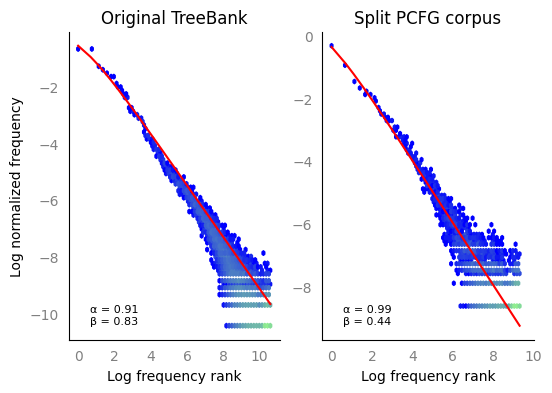

In [14]:
plot_Zipf_curve_comparison(PTB, AL, 'Original TreeBank', 'Split PCFG corpus')

## Shared levels

In [15]:
# read in shared_levels_PTB.txt
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/shared_levels_PTB.txt')
with open(shared_levels_path) as f:
    shared_levels = f.readlines()

skipped_idx = []
for i, sentence in enumerate(PTB):
    if len(sentence) >= cutoff_max or len(sentence) <= cutoff_min:
        skipped_idx.append(i)

shared_levels = [i for j, i in enumerate(shared_levels) if j not in skipped_idx]
shared_levelsPTB = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPTB)

130950

In [16]:
shared_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/train_shared_withoutROOT.txt')
with open(shared_levels_path) as f:
    shared_levels = f.readlines()

shared_levelsPCFG = [int(l.replace('\n', '')) for sentence in shared_levels for l in sentence.split(' ') if l != '\n']
len(shared_levelsPCFG)

105960

In [17]:
def stats_shared_levels(data, name):
    print(
        f"""
        {name:}
        The amount of labels is {len(data)}.
        There are {len(set(data))} unique labels.
        The labels are: {set(data)}.
        """
    )

In [18]:
stats_shared_levels(shared_levelsPTB, name='PTB')
stats_shared_levels(shared_levelsPCFG, name='PCFG')


        PTB
        The amount of labels is 130950.
        There are 23 unique labels.
        The labels are: {0, 1, 2, 3, 4, 5, 6, 7, -15, -14, -13, -12, -11, -2, -9, -8, -7, -6, -5, -4, -3, -1, -10}.
        

        PCFG
        The amount of labels is 105960.
        There are 27 unique labels.
        The labels are: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1}.
        


In [19]:
def plot_shared_levels(datasets, names):
    plt.hist(datasets[0], density=True, alpha=0.7, label=names[0])
    plt.hist(datasets[1], density=True, alpha=0.7, label=names[1])

    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.get_yaxis().set_visible(False) 

    plt.xlabel('Relative shared levels')
    plt.title('Relative shared levels of PTB and PCFG')
    plt.legend()

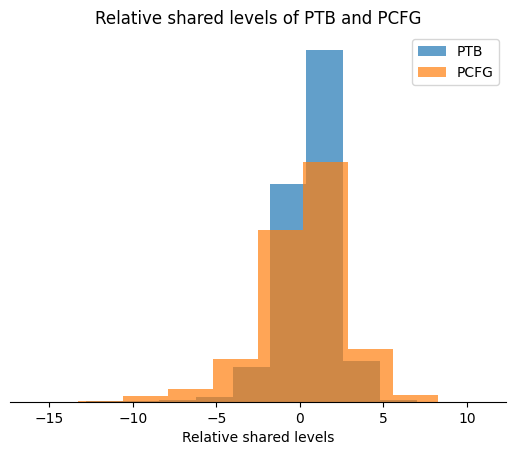

In [20]:
plot_shared_levels([shared_levelsPTB, shared_levelsPCFG], ['PTB', 'PCFG'])

## Chunking (distribution BIES labels)

In [56]:
bies_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_chunk/train_bies_orig_simple.txt')
with open(bies_levels_path) as f:
    bies_labelsPTB = f.readlines()

bies_labelsPTB = [word.replace('\n', '') for sent in bies_labelsPTB for word in sent.split(' ')]
stats_shared_levels(bies_labelsPTB, name='PTB')



        PTB
        The amount of labels is 190894.
        There are 5 unique labels.
        The labels are: {'B', 'E', 'S', 'PCT', 'I'}.
        


In [72]:
bies_labels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/train_bies_labels.txt')
with open(bies_labels_path) as f:
    bies_labelsPCFG = [word.replace('\n', '') for sent in f.readlines() for word in sent.split(' ')]
stats_shared_levels(bies_labelsPCFG, name='PCFG')
Counter(bies_labelsPCFG)


        PCFG
        The amount of labels is 115960.
        There are 5 unique labels.
        The labels are: {'B', 'E', 'S', 'PCT', 'I'}.
        


Counter({'B': 47010, 'E': 27433, 'S': 24214, 'PCT': 17283, 'I': 20})

In [117]:
def bies_labels_comparison(dataPTB, dataPCFG):
    fig = plt.subplots(figsize =(8, 4)) 
    barWidth = 0.4

    # Set position of bar on X axis 
    br1 = np.arange(len(Counter(dataPTB))) 
    br2 = [x + barWidth for x in br1] 

    # Sort dictionaries on key
    dataPTB = dict(sorted(Counter(dataPTB).items()))
    dataPCFG = dict(sorted(Counter(dataPCFG).items()))
    
    # # Make the plot
    plt.bar(br1, Counter(dataPTB).values(), color ='#FF7F0E', alpha=0.9, width = barWidth, 
            label ='PTB') 
    plt.bar(br2, Counter(dataPCFG).values(), color ='#1F77B4', alpha=0.9, width = barWidth, 
            label ='PCFG') 
    
    # Add count labels above each bar
    for i, count in enumerate(Counter(dataPTB).values()):
        plt.text(br1[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')

    for i, count in enumerate(Counter(dataPCFG).values()):
        if count <= 100:
                plt.text(br2[i], 2000, str(count), ha='center', color='black', size=8, weight='bold')
        else:
                plt.text(br2[i], 2000, str(count), ha='center', color='white', size=8, weight='bold')
    
    # Axis
    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.tick_params(bottom=False, left=False)

    # Adding Xticks 
    plt.grid(axis='y', alpha=0.5)
    plt.xticks([r + (barWidth / 2) for r in range(len(Counter(dataPTB)))], 
            Counter(dataPTB).keys())
    plt.yticks(np.arange(0, 100000, 20000))

    plt.xlabel('BIES labels') 
    plt.ylabel('Frequency') 
    plt.title('BIES labels per dataset.')
    
    plt.legend()

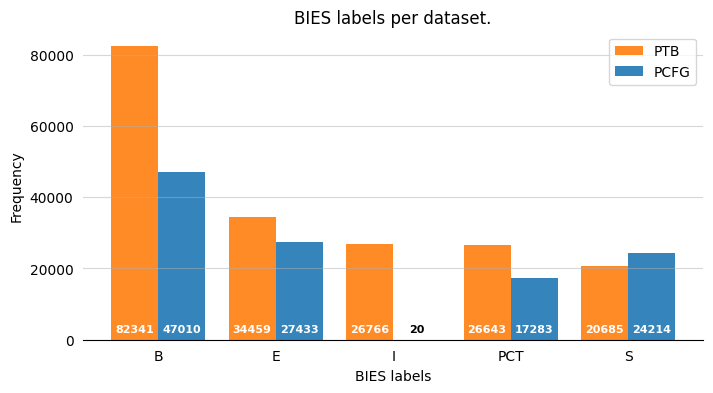

In [118]:
bies_labels_comparison(bies_labelsPTB, bies_labelsPCFG)

## LCA labels

In [120]:
lca_levels_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_lca/train_lca_orig_rel_labels.txt')
with open(lca_levels_path) as f:
    lca_labelsPTB = f.readlines()

lca_labelsPTB = [word.replace('\n', '') for sent in lca_labelsPTB for word in sent.split(' ')]
stats_shared_levels(lca_labelsPTB, name='PTB')


        PTB
        The amount of labels is 10328399.
        There are 29 unique labels.
        The labels are: {'', 'LST', 'SBAR', 'ADVP|PRT', 'PRN', 'WHNP', 'ADJP', 'WHADVP', 'WHPP', 'SBARQ', 'UCP', 'NX', 'NAC', 'RRC', 'S', 'SQ', 'PRT|ADVP', 'PRT', 'QP', 'PP', 'FRAG', 'SINV', 'X', 'NP', 'VP', 'ADVP', 'INTJ', 'CONJP', 'WHADJP'}.
        


In [124]:
lca_sampled_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/constptbprobing/exp_lca/train_lca_orig_rel_labels_sampled.txt')
with open(lca_sampled_path) as f:
    lca_sampledPTB = f.readlines()

lca_sampledPTB = [word.replace('\n', '') for sent in lca_sampledPTB for word in sent.split(' ')]
stats_shared_levels(lca_sampledPTB, name='PTB')


        PTB
        The amount of labels is 44958.
        There are 28 unique labels.
        The labels are: {'LST', 'SBAR', 'ADVP|PRT', 'PRN', 'WHNP', 'ADJP', 'WHADVP', 'WHPP', 'SBARQ', 'UCP', 'NX', 'NAC', 'RRC', 'S', 'SQ', 'PRT|ADVP', 'PRT', 'QP', 'PP', 'FRAG', 'SINV', 'X', 'NP', 'VP', 'ADVP', 'INTJ', 'CONJP', 'WHADJP'}.
        


In [171]:
lca_PCFG_path = Path('/Users/sperdijk/Documents/Master/Jaar_3/Thesis/thesis_code/data/train_rel_labels.txt')
with open(lca_PCFG_path) as f:
    lca_PCFG = f.readlines()

lca_PCFG = [word.replace('\n', '') for sent in lca_PCFG for word in sent.split(' ')]
stats_shared_levels(lca_PCFG, name='PCFG')


        PCFG
        The amount of labels is 105960.
        There are 43 unique labels.
        The labels are: {'SBAR', 'ATSBAR', 'ATQP', 'ATNP', 'PRN', 'ATADJP', 'WHNP', 'ATSINV', 'ADJP', 'WHADVP', 'SBARQ', 'WHPP', 'NX', 'UCP', 'NAC', 'RRC', 'S', 'ATS', 'SQ', 'ATWHNP', 'PRT', 'ATSBARQ', 'QP', 'PP', 'FRAG', 'SINV', 'ATUCP', 'X', 'ATINTJ', 'NP', 'VP', 'ATPP', 'ADVP', 'ATPRT', 'ATPRN', 'INTJ', 'ATVP', 'ATADVP', 'ATSQ', 'ATCONJP', 'CONJP', 'WHADJP', 'ATFRAG'}.
        


In [169]:
def plot_lca(dataset, name):
    plt.figure(figsize=(12, 4))

    # sort counter of dataset by value
    dataset = dict(sorted(Counter(dataset).items(), key=lambda item: item[1], reverse=True))
    plt.bar(*zip(*dataset.items()), alpha=0.9)

    ax = plt.gca()
    ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.tick_params(bottom=False, left=False)

    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.5)


    plt.xlabel('Lowest common ancestor (LCA) label')
    plt.title(f'Distribution of LCA labels of {name}')

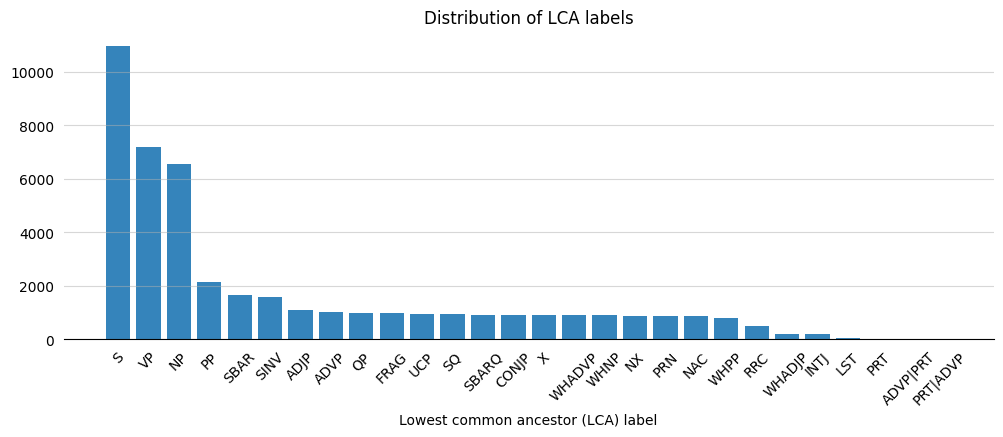

In [170]:
plot_lca(lca_sampledPTB, 'PTB')

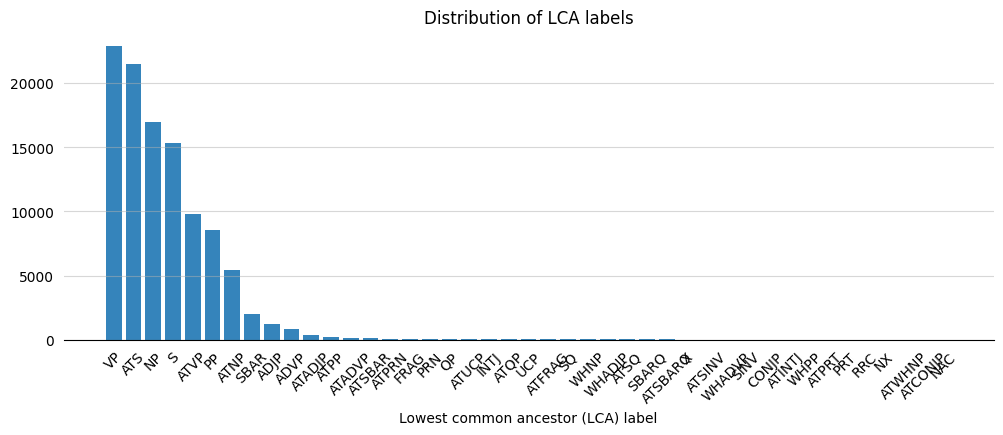

In [172]:
plot_lca(lca_PCFG, 'PCFG')